# CAR Variance and Covariance Tests 
$$
\newcommand{\var}{\operatorname{var}}
\newcommand{\cov}{\operatorname{cov}}
\newcommand{\N}{\mathcal N}
$$

In [1]:
import numpy as np
from math import exp, sqrt
import matplotlib.pyplot as plt
#import os
#os.chdir("/Users/mlysy/Documents/proj/buqDE/probDE")
#!python3 setup.py install
from BayesODE import var_car, cov_car

running install
running build
running build_py
creating build
creating build/lib
creating build/lib/BayesODE
copying BayesODE/cov_exp.py -> build/lib/BayesODE
copying BayesODE/bayes_ode.py -> build/lib/BayesODE
copying BayesODE/cov_rect.py -> build/lib/BayesODE
copying BayesODE/__init__.py -> build/lib/BayesODE
copying BayesODE/cov_car.py -> build/lib/BayesODE
copying BayesODE/utils.py -> build/lib/BayesODE
copying BayesODE/var_car.py -> build/lib/BayesODE
copying BayesODE/kalman_ode.py -> build/lib/BayesODE
copying BayesODE/cov_square_exp.py -> build/lib/BayesODE
package init file 'BayesODE/Tests/__init__.py' not found (or not a regular file)
creating build/lib/BayesODE/Tests
copying BayesODE/Tests/test_rect.py -> build/lib/BayesODE/Tests
copying BayesODE/Tests/ode_bayes_star.py -> build/lib/BayesODE/Tests
copying BayesODE/Tests/test_square_exp.py -> build/lib/BayesODE/Tests
copying BayesODE/Tests/test_exp.py -> build/lib/BayesODE/Tests
copying BayesODE/Tests/test_exp_integrate.py -> 

In [29]:
def rootgen(r0, p):
    """
    Creates p geometrically decaying CAR model roots.
    """
    roots = np.zeros(p)
    r = r0
    for k in range(p):
        roots[k] = -r
        r = exp(r0*(k+1))
    return roots

def V_euler(Gamma, Sigma, delta_t, N, B, X0=None):
    """
    Stochastic Euler approximation to the mOU variance.
    
    Parameters
    ----------
    Gamma : [p x p] numpy.ndarray
        mOU mean reversion matrix.
    Sigma : [p x p] numpy.ndarray
        mOU volatility matrix (positive-definite).
    delta_t : float
        Time interval between simulation points.
    N : int
        Number of simulation points.
    B : int
        Number of time series to calculate the variance from.
    X0 : [B x p] numpy.ndarray
        Optional starting point for the simulations.
    
    Returns
    -------
    V_t : [p x p] numpy.ndarray
        Monte Carlo estimate of `var(X_t | X_0 = x_0)`.
    """
    p = Gamma.shape[0]
    GammaT = Gamma.T
    X = np.zeros((N+1,B,p))
    if X0 is not None: X[0,:,:] = X0
    # simulate random draws
    Z = np.random.multivariate_normal(mean=np.zeros(p), 
                                      cov=delta_t*Sigma,
                                      size=(N,B))
    # step through
    for n in range(N):
        X[n+1] = X[n] + X[n].dot(GammaT)*delta_t + Z[n]
        # X[n] = X[n-1] + Gamma.dot(X[n-1])*delta_t + np.linalg.cholesky(Sigma).dot(deltaB_n)
    return np.cov(X[N], rowvar=False)

def mou_car(roots, sigma=1.):
    """
    Construct the `Gamma` and `Sigma` matrices out of the CAR specification.
    """
    delta = np.array(-roots)
    D = np.diag(delta)
    p = len(roots)
    Q = np.zeros((p, p))
    row = np.ones(p)
    for i in range(p):
        Q[i] = row
        row = row*roots
    Sigma = np.zeros((p, p))
    Sigma[p-1, p-1] = sigma*sigma
    Q_inv = np.linalg.pinv(Q)
    Gamma = np.zeros((p,p)) # Q*D*Q^-1
    Gamma[range(p-1),range(1,p)] = -1.
    Gamma[p-1] = np.linalg.multi_dot([Q[p-1], D, Q_inv])
    return Gamma, Sigma


## Variance as a function of time

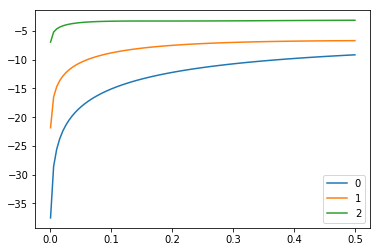

In [7]:
# quick picture
r0 = 1
p = 3
roots = rootgen(r0, p) #All roots need to be negative
tseq = np.linspace(0.001,0.5,100)
V = var_car(tseq, roots)
for k in range(len(roots)):
    plt.plot(tseq, np.log(V[:,k,k]), label=k)
plt.legend(loc='lower right')
plt.show()

In [35]:
# test against Euler

# car parameters
p = 3
r0 = np.random.uniform()
sigma = np.random.uniform()
roots = rootgen(r0, p)
# construct mOU process
Gamma, Sigma = mou_car(roots = roots, sigma = sigma)

B = 10000
tval = np.array([1.])
N = 1000
delta_t = tval/N
V_ex = var_car(tval, roots=roots, sigma=sigma) # exact variance
V_eu = V_euler(Gamma=Gamma, 
               Sigma=Sigma, 
               delta_t=delta_t, 
               N=N, 
               B=B, 
               X0=None)
(V_ex, V_eu)

(array([[[ 8.60465086e-04,  9.51909364e-04, -2.02010931e-03],
         [ 9.51909364e-04,  2.34096629e-03,  2.70375528e-05],
         [-2.02010931e-03,  2.70375528e-05,  3.42383391e-02]]]),
 array([[   1.61025816,   -7.96961599,   36.14529258],
        [  -7.96961599,   39.55399179, -179.75291367],
        [  36.14529258, -179.75291367,  818.17240538]]))

## Correlation as a function of time

First, let's calculate this analytically.  Suppose that the function `var_car` to compute $V_t = \var(X_t)$ is correct.  In fact what this is computing is $\var(X_t | X_0 = x_0)$, i.e., we condition on the value at $t = 0$ being fixed.  What we would like to compute with `cov_car` is $\cov(X_0, X_t)$ with $X_0 \sim \N(0, V_\infty)$ being drawn from its stationary distribution.

So we should modify the Euler simulation to draw the initial value randomly from this distribution.

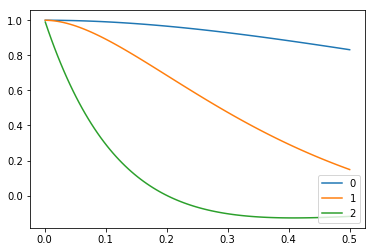

In [6]:
C = cov_car(tseq, roots, corr=True)
for k in range(len(roots)):
    plt.plot(tseq, C[:,k,k], label=k)
plt.legend(loc='lower right')
plt.show()

## Higher Order Solver

Let $y_t = (x^{(0)}_t, x^{(1)}_t, \ldots, x^{(q-1)}_t)$, such that the ODE is defined as

$$
a' y_t = F(y_t, t), \qquad y_0 = b,
$$

where $a_{q \times 1}$.  Note that this setup is somewhat flexible.  For instance you could use it to solve the ODE

$$
x^{(2)}_t + 2 x^{(1)}_t + \sin(x_t) + t = 0, \qquad x_0 = 2, \quad x^{(1)}_0 = 1.
$$

Then we could write

$$
a = (0, 1, 0), \quad F(y_t, t) = \frac{-x^{(2)}_t - \sin(x_t) - t}{2},
$$

or we could write

$$
a = (0, 2, 1), \quad F(y_t,t) = -\sin(x_t) - t.
$$

The solution prior is going to be on the CAR$(p)$ process $X_t = (x^{(0)}_t, \ldots, x^{(p-1)}_t)$ where $p > q$, such that the solution assumes at least $q-1$ continuous derivatives.

The algorithm goes like this:

1.  Let $X_0$ be compatible with $y_0 = c$.  I think a simple default is to assume that $X_0 \sim \N(0, V_{\infty})$, then condition on $y_0 = c$.  The first model interrogation is deterministic: $v_0^\star = F(y_0, 0)$ with variance $\Sigma_0^\star = 0$.
2.  Model interrogation:  Given that we have used the KF to store the mean and variance of $p(X_n \mid v_{0:n}^\star)$,
    - Do one forward step from Markov process $X_{n+1} \sim p(X_{n+1} \mid X_{0:n})$, via 
    
        $$
        X_n \sim p( \mid v_{0:n}^\star), \qquad X_{n+1} \sim p(X_{n+1} \mid X_n).
        $$
        
    - Interrogate $v_{n+1}^\star = F(y_{n+1}, t_{n+1})$, and calculate $\Sigma_{n+1}^\star = \var(a'y_{n+1} \mid v_{0:n}^{\star})$.
3.  Forward-pass update $p(X_{n+1} \mid v_{0:n+1}^\star)$, where the observation model is

    $$
    v_{n+1}^\star \sim \N(a'y_{n+1}, \Sigma_{n+1}^\star),
    $$
        
    where $y_{n+1}$ are the first $p+1$ elements of $X_{n+1}$.
4.  Once you've done this for $N$ steps, backward-pass update (KF smoothing) to get $p(X_{0:N} \mid v_{0:N}^{\star})$. 

In [11]:
def getgamma(C):
    gamma = np.zeros(C.shape)
    for t in range(C.shape[0]):
        D = np.diag(np.diag(C[t]))
        print(D)
        D_half = np.linalg.cholesky(D)
        gamma[t] = np.linalg.multi_dot([np.linalg.pinv(D_half), C[t], D_half])
    return gamma

In [12]:
gamma = getgamma(C)

[[0.9999991  0.         0.        ]
 [0.         0.99998496 0.        ]
 [0.         0.         0.98960069]]
[[0.99996701 0.         0.        ]
 [0.         0.99946062 0.        ]
 [0.         0.         0.93846673]]
[[0.99988902 0.         0.        ]
 [0.         0.99821629 0.        ]
 [0.         0.         0.88941392]]
[[0.99976516 0.         0.        ]
 [0.         0.99628958 0.        ]
 [0.         0.         0.84236325]]
[[0.99959554 0.         0.        ]
 [0.         0.9937166  0.        ]
 [0.         0.         0.79723865]]
[[0.99938027 0.         0.        ]
 [0.         0.99053196 0.        ]
 [0.         0.         0.75396684]]
[[0.99911949 0.         0.        ]
 [0.         0.98676886 0.        ]
 [0.         0.         0.7124773 ]]
[[0.99881339 0.         0.        ]
 [0.         0.98245913 0.        ]
 [0.         0.         0.67270209]]
[[0.99846215 0.         0.        ]
 [0.         0.97763329 0.        ]
 [0.         0.         0.63457583]]
[[0.99806599 0.    

LinAlgError: Matrix is not positive definite

In [8]:
gamma = getgamma(C)
for k in range(len(roots)):
    plt.plot(tseq, np.log(gamma[:,k,k]), label=k)
plt.legend(loc='upper left')
plt.show()
#plt.plot(tseq,gamma)

LinAlgError: Matrix is not positive definite

In [ ]:
def decorrelation(roots, k, tol=1e-5):
    t = 0.1
    
    while True:
        cov = cov_car(np.array([t]), roots)
        gamma_k = getgamma(cov)[0][k,k]
        if abs(gamma_k-1/exp(1)) < tol:
            return t
        elif gamma_k>1/exp(1):
            t = t - t/100
        else:
            t = t + t/100

In [ ]:
decorrelation(roots, 2)

# Unit Test

In [ ]:
r0 = 1
roots = rootgen(r0, 3)

delta = -roots
D = np.diag(delta)
p = len(roots)
Q = np.zeros((p, p))

row = np.ones(p)
for i in range(p):
    Q[i] = row
    row = row*roots

Q_inv = np.linalg.pinv(Q)
Gamma = np.linalg.multi_dot([Q, D, Q_inv])

In [ ]:
from sympy import symbols, expand, Poly
s = symbols('s')
product = 1
for root in roots:
    product = product * (s - root)
coeffs = Poly(expand(product)).coeffs()
np.allclose(np.array(coeffs[:0:-1], dtype='float'),Gamma[-1])

In [ ]:
def V_euler_N1(Sigma, Delta_t):
    return Sigma*Delta_t

In [ ]:
def var_car_test(Q, D, Sigma, Delta_t):
    p = len(D)
    delta = np.diag(D)
    Q_inv = np.linalg.pinv(Q)
    Gamma = np.linalg.multi_dot([Q, D, Q_inv]) #Q*D*Q^-1
    Sigma_tilde = np.linalg.multi_dot([Q_inv, Sigma, Q_inv.T]) #Q^-1*Sigma*Q^-1'

    V_tilde = np.zeros((p,p))
    for i in range(p):
        for j in range(i, p):
            V_tilde[i,j] = Sigma_tilde[i,j] / (delta[i] + delta[j]) * (1- exp(- (delta[i] + delta[j]) * Delta_t)) #V_tilde
            V_tilde[j,i] = V_tilde[i,j]

    V = np.linalg.multi_dot([Q, V_tilde, Q.T]) #V_deltat
    return V

In [ ]:
Delta_T = 10**-np.linspace(5, 10, 10)
Q = np.ones((3,3))
D = np.diag([1,2,3])
Sigma = np.random.rand(3,3)
Sigma = Sigma.dot(Sigma.T)

compare = np.zeros(len(Delta_T))
for t in range(len(Delta_T)):
    euler = V_euler_N1(Sigma, Delta_T[t])
    true = var_car_test(Q, D, Sigma, Delta_T[t])
    compare[t] = np.max((abs(euler - true)/(abs(euler) + 0.1)))
    
plt.plot(np.log10(Delta_T), compare)

In [ ]:
def V_euler(B, N, Sigma, Gamma, delta_t):
    p = len(Gamma)
    X = np.zeros((N,p,B))
    Z = np.random.normal(0,1,(N,p,B))
    for n in range(N):
        deltaB_n = sqrt(delta_t)*Z[n]
        if n==0:
            X[n] = np.linalg.cholesky(Sigma).dot(deltaB_n)
        else:
            X[n] = X[n-1] + Gamma.dot(X[n-1])*delta_t + np.linalg.cholesky(Sigma).dot(deltaB_n)
    return np.cov(X[N-1])

In [ ]:
Q = np.ones((3,3))
Q_inv = np.linalg.pinv(Q)
D = np.diag([1,2,3])
Sigma = np.random.rand(3,3)
Sigma = Sigma.dot(Sigma.T)
Gamma = np.linalg.multi_dot([Q, D, Q_inv]) #Q*D*Q^-1

B = 10000
N = 10
T = 10**-np.linspace(5, 10, 10)

compare = np.zeros(len(T))
for t in range(len(T)):
    euler = V_euler(B, N, Sigma, Gamma, T[t]/N)
    true = var_car_test(Q, D, Sigma, T[t])
    compare[t] = np.max((abs(euler - true)/(abs(euler) + 0.1)))
    
plt.plot(np.log10(Delta_T), compare)